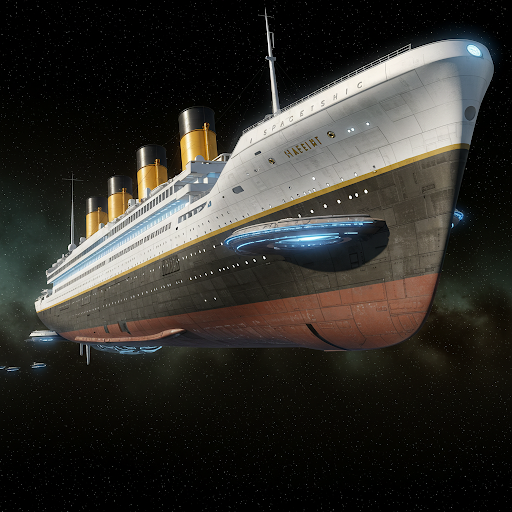

# **Space Titanic** By: Thabo Pilusa

**Method 1: TabPFN**

In [ ]:
pip install tabpfn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tabpfn import TabPFNClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Load data
train_df = pd.read_csv("train_titanic.csv")
test_df = pd.read_csv("test_titanic.csv")

# Drop unused columns
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
train_df_tabpfn = train_df.drop(columns=cols_to_drop)
test_df_tabpfn = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns])

# Handle missing values
for col in train_df_tabpfn.columns:
    if train_df_tabpfn[col].dtype == "object":
        train_df_tabpfn[col] = train_df_tabpfn[col].fillna("Unknown")
    else:
        train_df_tabpfn[col] = train_df_tabpfn[col].fillna(train_df_tabpfn[col].median())

for col in test_df_tabpfn.columns:
    if test_df_tabpfn[col].dtype == "object":
        test_df_tabpfn[col] = test_df_tabpfn[col].fillna("Unknown")
    else:
        test_df_tabpfn[col] = test_df_tabpfn[col].fillna(test_df_tabpfn[col].median())

# Label encoding
label_encoders_tabpfn = {}
for col in train_df_tabpfn.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    train_df_tabpfn[col] = le.fit_transform(train_df_tabpfn[col])
    label_encoders_tabpfn[col] = le
    if col in test_df_tabpfn.columns:
        test_df_tabpfn[col] = le.transform(test_df_tabpfn[col])

# Train/Validation split for internal evaluation
X_tabpfn = train_df_tabpfn.drop(columns=["Survived"])
y_tabpfn = train_df_tabpfn["Survived"]
X_train_tabpfn, X_val_tabpfn, y_train_tabpfn, y_val_tabpfn = train_test_split(
    X_tabpfn, y_tabpfn, test_size=0.2, random_state=42
)

# Train TabPFN model
clf_tabpfn = TabPFNClassifier(device="cpu")  # Change to 'cuda' if using GPU
clf_tabpfn.fit(X_train_tabpfn.to_numpy(), y_train_tabpfn.to_numpy())

# Evaluate on validation set using AUC
val_probs_tabpfn = clf_tabpfn.predict_proba(X_val_tabpfn.to_numpy())[:, 1]  # Get probabilities for the positive class
fpr_tabpfn, tpr_tabpfn, _ = roc_curve(y_val_tabpfn, val_probs_tabpfn)
roc_auc_tabpfn = auc(fpr_tabpfn, tpr_tabpfn)

print(f"TabPFN Validation AUC: {roc_auc_tabpfn:.4f}")

# Prepare test predictions for Kaggle
X_test_tabpfn = test_df_tabpfn[X_tabpfn.columns]  # Ensure feature alignment
test_preds_tabpfn = clf_tabpfn.predict(X_test_tabpfn.to_numpy())

submission_tabpfn = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_preds_tabpfn
})
submission_tabpfn.to_csv("tabpfn_titanic.csv", index=False)
print("Submission saved as tabpfn_titanic.csv")


/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:89: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/tabpfn/classifier.py:431: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)


TabPFN Validation AUC: 0.8937
Submission saved as tabpfn_titanic.csv


**Method 2: Radom Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Load data
train_df = pd.read_csv("train_titanic.csv")
test_df = pd.read_csv("test_titanic.csv")
# Drop unused columns
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
train_data = train_df.drop(columns=cols_to_drop)
test_data = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns])

# Fill missing values
for col in train_data.columns:
    if train_data[col].dtype == "object":
        train_data[col] = train_data[col].fillna("Unknown")
    else:
        train_data[col] = train_data[col].fillna(train_data[col].median())

for col in test_data.columns:
    if test_data[col].dtype == "object":
        test_data[col] = test_data[col].fillna("Unknown")
    else:
        test_data[col] = test_data[col].fillna(test_data[col].median())

# Label encoding
label_encoders = {}
for col in train_data.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le
    if col in test_data.columns:
        test_data[col] = le.transform(test_data[col])

# Train/Validation split
X_train_rf = train_data.drop(columns=["Survived"])
y_train_rf = train_data["Survived"]
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_train_rf, y_train_rf, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)

# Evaluate using AUC
val_probs_rf = rf.predict_proba(X_val_rf)[:, 1]  # Get probabilities for the positive class
fpr_rf, tpr_rf, _ = roc_curve(y_val_rf, val_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

print(f"Random Forest Validation AUC: {roc_auc_rf:.4f}")

# Prepare test predictions
X_test_rf = test_data[X_train_rf.columns]  # ensure same features as training
test_preds_rf = rf.predict(X_test_rf)

submission_rf = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_preds_rf
})
submission_rf.to_csv("rf_titanic.csv", index=False)
print("Submission saved as rf_titanic.csv")


Random Forest Validation AUC: 0.8966
Submission saved as rf_titanic.csv


**Method 3: XGBOOST**

In [ ]:
from xgboost import XGBClassifier


# Drop unused columns
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
train_data = train_df.drop(columns=cols_to_drop)
test_data = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns])

# Fill missing values
for col in train_data.columns:
    if train_data[col].dtype == "object":
        train_data[col] = train_data[col].fillna("Unknown")
    else:
        train_data[col] = train_data[col].fillna(train_data[col].median())

for col in test_data.columns:
    if test_data[col].dtype == "object":
        test_data[col] = test_data[col].fillna("Unknown")
    else:
        test_data[col] = test_data[col].fillna(test_data[col].median())

# Label encoding
label_encoders = {}
for col in train_data.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le
    if col in test_data.columns:
        test_data[col] = le.transform(test_data[col])

# Split train/validation
X_train_xgb = train_data.drop(columns=["Survived"])
y_train_xgb = train_data["Survived"]
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train_xgb, y_train_xgb, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predictions & evaluation
val_probs_xgb = xgb_model.predict_proba(X_val_xgb)[:, 1]  # Get probabilities for the positive class
fpr_xgb, tpr_xgb, _ = roc_curve(y_val_xgb, val_probs_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

print(f"XGBOOST Validation AUC: {roc_auc_xgb:.4f}")

# Test predictions
X_test_xgb = test_data[X_train_xgb.columns]  # ensure matching features
test_preds_xgb = xgb_model.predict(X_test_xgb)

submission_xgb = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_preds_xgb
})
submission_xgb.to_csv("xgboost_titanic.csv", index=False)
print("Submission saved as xgboost_titanic.csv")


XGBOOST Validation AUC: 0.8672
Submission saved as xgboost_titanic.csv


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


**Method 4: LightGBM**

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Drop irrelevant columns
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
train_data = train_df.drop(columns=cols_to_drop)
test_data = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns])

# Fill missing values
for col in train_data.columns:
    if train_data[col].dtype == "object":
        train_data[col] = train_data[col].fillna("Unknown")
    else:
        train_data[col] = train_data[col].fillna(train_data[col].median())

for col in test_data.columns:
    if test_data[col].dtype == "object":
        test_data[col] = test_data[col].fillna("Unknown")
    else:
        test_data[col] = test_data[col].fillna(test_data[col].median())

# Encode categorical features
label_encoders = {}
for col in train_data.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le
    if col in test_data.columns:
        test_data[col] = le.transform(test_data[col])

# Train-validation split
X_train_lgb = train_data.drop(columns=["Survived"])
y_train_lgb = train_data["Survived"]
X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(X_train_lgb, y_train_lgb, test_size=0.2, random_state=42)

# Train LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_lgb, y_train_lgb)

# Predictions
val_probs_lgb = lgb_model.predict_proba(X_val_lgb)[:, 1]  # Get probabilities for the positive class
fpr_lgb, tpr_lgb, _ = roc_curve(y_val_lgb, val_probs_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

print(f"LightGBM Validation AUC: {roc_auc_lgb:.4f}")

# Predict on test set
X_test_lgb = test_data[X_train_lgb.columns]  # ensure feature alignment
test_preds_lgb = lgb_model.predict(X_test_lgb)

# Create submission
submission_lgb = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_preds_lgb
})
submission_lgb.to_csv("lightgbm_titanic.csv", index=False)
print("Submission saved as lightgbm_titanic.csv")


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


**Model Perfomance Comparison**

<ipython-input-13-1aad6aa9db49>:19: UserWarning: Glyph 128674 (\N{SHIP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128674 (\N{SHIP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


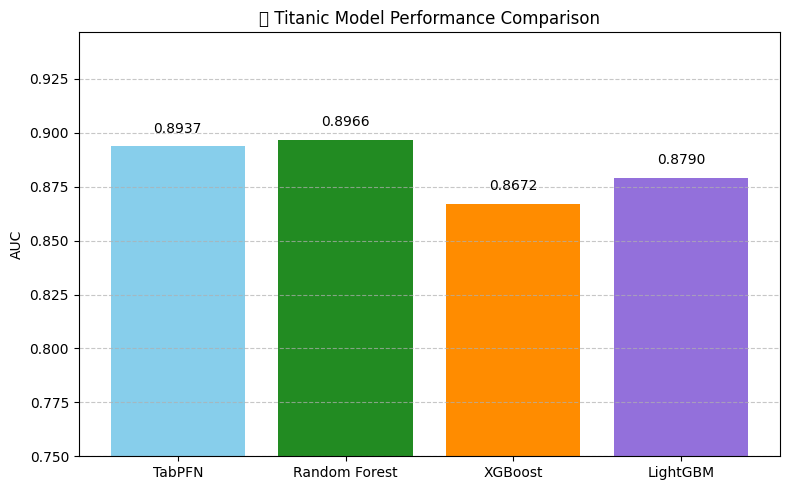

In [ ]:
import matplotlib.pyplot as plt

# Model names and corresponding accuracy values
model_names = ["TabPFN", "Random Forest", "XGBoost", "LightGBM"]
accuracies = [roc_auc_tabpfn, roc_auc_rf, roc_auc_xgb, roc_auc_lgb]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=["skyblue", "forestgreen", "darkorange", "mediumpurple"])
plt.ylabel("AUC")
plt.title("🚢 Titanic Model Performance Comparison")
plt.ylim(0.75, max(accuracies) + 0.05)

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.005, f"{acc:.4f}", ha='center', va='bottom')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()




Public Score on KAGGLE (TapPFN Performs Better)

- tabpfn: 0.77751
- rf: 0.74641
- lightgbm: 0.72248
- xgboost: 0.69617




**Hyperparameter Tuning for Tabpfn Model**

In [ ]:
import pandas as pd
import numpy as np
from tabpfn import TabPFNClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Load data
train_df = pd.read_csv("train_titanic.csv")
test_df = pd.read_csv("test_titanic.csv")

# Preprocessing
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
train_df_tabpfn = train_df.drop(columns=cols_to_drop)
test_df_tabpfn = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns])

# Handle missing values
for col in train_df_tabpfn.columns:
    if train_df_tabpfn[col].dtype == "object":
        train_df_tabpfn[col] = train_df_tabpfn[col].fillna("Unknown")
    else:
        train_df_tabpfn[col] = train_df_tabpfn[col].fillna(train_df_tabpfn[col].median())

for col in test_df_tabpfn.columns:
    if test_df_tabpfn[col].dtype == "object":
        test_df_tabpfn[col] = test_df_tabpfn[col].fillna("Unknown")
    else:
        test_df_tabpfn[col] = test_df_tabpfn[col].fillna(test_df_tabpfn[col].median())

# Label encoding
label_encoders_tabpfn = {}
for col in train_df_tabpfn.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    train_df_tabpfn[col] = le.fit_transform(train_df_tabpfn[col])
    label_encoders_tabpfn[col] = le
    if col in test_df_tabpfn.columns:
        test_df_tabpfn[col] = le.transform(test_df_tabpfn[col])

# Train/Validation split
X_tabpfn = train_df_tabpfn.drop(columns=["Survived"])
y_tabpfn = train_df_tabpfn["Survived"]
X_train_tabpfn, X_val_tabpfn, y_train_tabpfn, y_val_tabpfn = train_test_split(
    X_tabpfn, y_tabpfn, test_size=0.2, random_state=42
)

# Hyperparameter grid (only device is tunable)
param_grid = {
    'device': ['cpu']  # Only test CPU vs CUDA if available
}

best_auc = 0
best_params = {}

print("🚀 Starting hyperparameter tuning...")
for device in param_grid['device']:
    print(f"\n⚙️ Testing config: device={device}")

    clf = TabPFNClassifier(
        device=device  # Only specify supported parameters
    )

    clf.fit(X_train_tabpfn.values, y_train_tabpfn.values)
    val_probs = clf.predict_proba(X_val_tabpfn.values)[:, 1]
    current_auc = auc(*roc_curve(y_val_tabpfn, val_probs)[:2])

    print(f"✅ Validation AUC: {current_auc:.4f}")

    if current_auc > best_auc:
        best_auc = current_auc
        best_params = {'device': device}

print(f"\n🎉 Best validation AUC: {best_auc:.4f}")
print("🔍 Best parameters:", best_params)

# Train final model with best parameters on full data
print("\n🚀 Training final model with best parameters...")
final_clf = TabPFNClassifier(**best_params)
final_clf.fit(X_tabpfn.to_numpy(), y_tabpfn.to_numpy())

# Prepare test predictions
X_test_tabpfn = test_df_tabpfn[X_tabpfn.columns]
test_preds = final_clf.predict(X_test_tabpfn.to_numpy())

# Generate submission
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_preds
})
submission.to_csv("tuned_tabpfn_titanic.csv", index=False)
print("📁 Final submission saved as tuned_tabpfn_titanic.csv")

🚀 Starting hyperparameter tuning...

⚙️ Testing config: device=cpu


/usr/local/lib/python3.11/dist-packages/tabpfn/classifier.py:431: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)


✅ Validation AUC: 0.8937

🎉 Best validation AUC: 0.8937
🔍 Best parameters: {'device': 'cpu'}

🚀 Training final model with best parameters...


/usr/local/lib/python3.11/dist-packages/tabpfn/classifier.py:431: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)


📁 Final submission saved as tuned_tabpfn_titanic.csv


- Tune the Random Forest model to see its perfomance relative to the tuned TabPFN model

**Tuning the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
import pandas as pd
import numpy as np

# Drop unused columns
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
train_data = train_df.drop(columns=cols_to_drop)
test_data = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns])

# Fill missing values
for col in train_data.columns:
    if train_data[col].dtype == "object":
        train_data[col] = train_data[col].fillna("Unknown")
    else:
        train_data[col] = train_data[col].fillna(train_data[col].median())

for col in test_data.columns:
    if test_data[col].dtype == "object":
        test_data[col] = test_data[col].fillna("Unknown")
    else:
        test_data[col] = test_data[col].fillna(test_data[col].median())

# Label encoding
label_encoders = {}
for col in train_data.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le
    if col in test_data.columns:
        test_data[col] = le.transform(test_data[col])

# Train/Validation split
X = train_data.drop(columns=["Survived"])
y = train_data["Survived"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 🎯 Hyperparameter Tuning
param_dist = {
    "n_estimators": randint(100, 1000),
    "max_depth": [None] + list(range(5, 20)),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}

rf_base = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# 🚀 Best model
best_rf = random_search.best_estimator_
print(f"Best Params: {random_search.best_params_}")

# 📊 Evaluate
val_probs = best_rf.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)

print(f"✅ Tuned Random Forest Validation AUC: {roc_auc:.4f}")

# 📁 Test predictions
X_test = test_data[X.columns]
test_preds = best_rf.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_preds
})
submission.to_csv("rf_tuned_titanic.csv", index=False)
print("📁 Submission saved as rf_tuned_titanic.csv")



# Get predicted probabilities for validation set
val_probs = best_rf.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)

print(f"🎯 Tuned Random Forest Validation AUC: {roc_auc:.4f}")



Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
85 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best Params: {'bootstrap': True, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 863}
✅ Tuned Random Forest Validation AUC: 0.9022
📁 Submission saved as rf_tuned_titanic.csv
🎯 Tuned Random Forest Validation AUC: 0.9022


🏁🏁🏁🏁🏁**The tuned Random Forest model performs better, with AUC of 0.9022 and providing a public score of 0.77990 on kaggle.**